In [1]:
# Name:ABDULRAHMAN ALABRASH
# Student ID: 68383

# Linear Regression on Housing Data
In the first lab assignment, you played with Boston Housing Dataset. In this lab assignment, you are going to implement a linear regression model trained on Boston Housing Data by using Knet for the first time. We will take advantage of iterators, callable objects and automatic differentation mechanism.

In [2]:
# Necessary imports
using Pkg; for p in ("Knet","AutoGrad","Plots","Images","ImageMagick"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using Knet
using Statistics
using Random
import Base: length, size, iterate, eltype, IteratorSize, IteratorEltype, haslength, @propagate_inbounds, repeat, rand, tail
import .Iterators: cycle, Cycle, take
using Plots; default(fmt=:png,ls=:auto)

## Data Reading
You do not need to worry about data reading and preprocessing: We are going to take advantage of housing data reader which is also a part of Knet. We include some source file and then use ```housing``` function. ```housing``` function takes one input argument: the percentage of the test set to split dataset into two parts. Just take a look at the cell below. In this lab session, we are going to use 20% of the data as test split.

In [3]:
include(joinpath(Knet.dir(), "data", "housing.jl"))
Knet.seed!(1)
xtrn, ytrn, xtst, ytst = housing(0.20; url="https://raw.githubusercontent.com/ilkerkesen/ufldl-tutorial/master/ex1/housing.data")

([-0.410443 -0.113706 … -0.328758 -0.415011; -0.48724 -0.48724 … 0.370303 2.94293; … ; 0.37599 -0.068175 … 0.300082 0.440616; 0.185818 -0.00182931 … 0.299246 -0.337914], [26.4 16.1 … 30.7 19.4], [-0.40099 -0.416566 … -0.403706 -0.405478; 0.456057 -0.48724 … -0.48724 1.44223; … ; 0.197557 0.417723 … 0.440616 0.286609; -0.438739 -0.293103 … 0.446283 -1.13331], [24.5 18.5 … 20.3 29.8])

In [4]:
size(xtrn), size(ytrn), size(xtst), size(ytst)

((13, 405), (1, 405), (13, 101), (1, 101))

## Minibatching via Iterators
In this part, you are going implement a minibatching procedure (or let's call it pipeline). Remember, you need to implement your own ```minibatch``` function, it's forbidden to use Knet's ```minibatch``` procedure. Also, your minibatching scheme must use iterators. Just take a look at [this blog post](https://julialang.org/blog/2018/07/iterators-in-julia-0.7). To implement your minibatching pipeline, we provide you ```HousingData``` struct definition. Different from the original implementation, you are not going to discard the last remaining smaller minibatch, you will use all the instances. Also, remember that, ```HousingData``` structure is not mutable which means you are not able to change the values inside struct.

In [5]:
# DO NOT TOUCH THIS CELL
struct HousingDataMinibatch
    x
    y
    batchsize
    shuffle # shuffle data in each epoch or not
    ninstances # number of instances
end

In [6]:
# This function constructs a HousingData object
function HousingDataMinibatch(x, y; batchsize=100, dtype=Array{Float64}, shuffle=false)
    # start your answer
    nins=size(x,2)
    house=HousingDataMinibatch(x,y,batchsize,shuffle,nins)
    house
    # end your answer
end
#

HousingDataMinibatch

In [7]:
convert(Int64,ceil(7/4))#Float64

2

In [8]:
# Returns how many batches the dataset has (hint: you can use divrem function)
function length(d::HousingDataMinibatch)
    # start your answer
#     n=0
#     for (x,y) in d:
#         n+=1
#     return n
    convert(Int64,ceil(d.ninstances/d.batchsize))
    # end your answer
end

length (generic function with 150 methods)

In [9]:
# Returns a random minibatch (hint: you can use randperm function)
function rand(d::HousingDataMinibatch)
    # start your answer
    indx=randperm(d.ninstanace)[1:d.batchsize]
    x=d.x[:,indx]
    y=d.y[:,indx]
    # end your answer
    return (x, y)
end

rand (generic function with 70 methods)

In [10]:
@doc next

No documentation found.

Binding `next` does not exist.


In [11]:
# This is how you implement your own iterator!
function iterate(d::HousingDataMinibatch, state=ifelse(d.shuffle, randperm(d.ninstances), 1:d.ninstances))
#   if state is not given it will start from 0, 
    # start your answer
    i=min(size(state,1),d.batchsize)
    
    if size(state,1)==0
        return nothing
    else 
        
        x=d.x[:,state[1:i]]
        y=d.y[:,state[1:i]]
        #doing this will make the polt  smooth 
#         x=d.x[:,1:i]
#         y=d.y[:,1:i]
        state=state[d.batchsize+1:end]
    end
    return (x,y),state
    # end your answer
end

iterate (generic function with 276 methods)

In [12]:
dtrn = HousingDataMinibatch(xtrn, ytrn; shuffle=true)
dtst = HousingDataMinibatch(xtst, ytst)

HousingDataMinibatch([-0.40099 -0.416566 … -0.403706 -0.405478; 0.456057 -0.48724 … -0.48724 1.44223; … ; 0.197557 0.417723 … 0.440616 0.286609; -0.438739 -0.293103 … 0.446283 -1.13331], [24.5 18.5 … 20.3 29.8], 100, false, 101)

In [13]:
# just testing
for (x, y) in dtrn
    println(size(x), ", ", size(y))
end

# needs to have the following output
# (13, 100), (1, 100)
# (13, 100), (1, 100)
# (13, 100), (1, 100)
# (13, 100), (1, 100)
# (13, 5), (1, 5)

(13, 100), (1, 100)
(13, 100), (1, 100)
(13, 100), (1, 100)
(13, 100), (1, 100)
(13, 5), (1, 5)


## Model Implementation via Callable Objects
Next, we are going to implement our model via callable objects. In Julia, we can call objects. Just give a glimpse at the following code snippet:

In [14]:
struct Hello
    planet
    Hello(planet="World") = new(planet)
end

(obj::Hello)() = println("Hello, $(obj.planet)!")

hello_world = Hello()
hello_world()

hello_jupiter = Hello("Jupiter")
hello_jupiter()

Hello, World!
Hello, Jupiter!


For this assingment, you just need to define a linear layer and that's all! Write your solutions to the below cell. Hint: You need to use ```Param``` method of AutoGrad. Just type ```@doc Param``` to see the documentation.

In [15]:
struct Linear; w; b; end

function (l::Linear)(x)
    # start your answer
    l.w*x.+l.b
    # end your answer
end

function Linear(xsize::Int, ysize::Int, atype=Array{Float64}, scale=0.1)
    # start your answer
    Linear(Param(scale * randn(ysize,xsize)),Param(zeros(ysize)))
    
    # end your answer
end

model = Linear(13, 1)

Linear(P(Array{Float64,2}(1,13)), P(Array{Float64,1}(1)))

## Define Loss Function
In this part, we'll define our loss function. We are going to use minimum squared error loss function,

![MSE](http://web.itu.edu.tr/keseni/mse.png)

We're going to define three diffent functions for this purpose,

1. A function takes predictions and gold values as input.
2. A callable object procedure that takes input/output pair as input
3. A callable object procedure that takes our dataset object as input

See function prototypes below and the documentation of ```train!``` function.

In [16]:
# 1 - takes predictions and gold values as input.
function mse(ypred, ygold)
    # start your answer
    sum(abs2,ygold-ypred)/(2*size(ypred,2))
    # end your answer
end


# 2 - callable object procedure that takes input/output pair as input
function (m::Linear)(x, y)
    # start your answer
    mse(m(x),y)
    # end your answer
end


# 3 - callable object procedure that takes our dataset object as input
function (m::Linear)(data::HousingDataMinibatch)
    # start your answer
    mean(m(x,y) for (x,y) in data)
    # end your answer
end

## Training with Modular Interface and Iterators
Now, let's implement a ```mytrain!``` procedure to train our network! It takes model, train data, test data, report period (in iterations) and number of maximum iterations. It trains our model until a certain maximum iterations number, records loss values of train and test data splits after each report period. It should output three lists: iterations numbers, loss values of train set, loss values of test set.

Hint: You will need ```sgd!```, ```cycle``` and ```take``` procedures.

Finally, let's train our network and plot the results,

In [17]:
function mytrain!(m::Linear, dtrn, dtst, valid=10, max_iters=500)
    # start your answer
    trnloss=Float32[]
    tstloss=Float32[]
    push!(trnloss,m(dtrn))
    push!(tstloss,m(dtst))
    for (i,j) in enumerate(sgd(m,take(cycle(dtrn),max_iters),lr=0.01))
            if i% valid==0
                push!(trnloss,m(dtrn))
                push!(tstloss,m(dtst))
            end
        end
    # end your answer
    return 0:valid:max_iters, trnloss, tstloss
end

mytrain! (generic function with 3 methods)

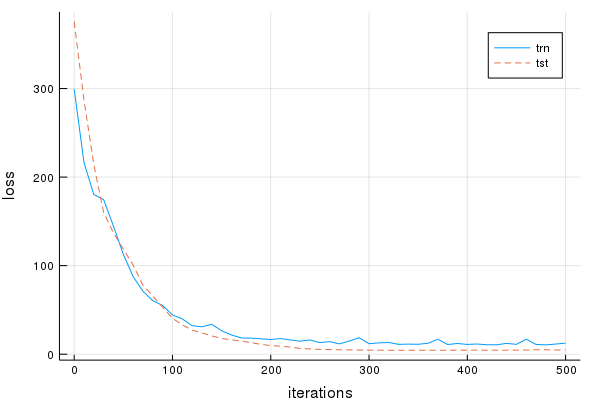

In [18]:
Knet.seed!(42)
model = Linear(13, 1)
dtrn = HousingDataMinibatch(xtrn, ytrn; shuffle=true)
dtst = HousingDataMinibatch(xtst, ytst)
iters, trnloss, tstloss = mytrain!(model, dtrn, dtst)
plot(iters, [trnloss, tstloss], labels=[:trn, :tst], xlabel="iterations", ylabel="loss")